In [1]:
import numpy as np
import cv2
import matplotlib
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import json
from tqdm import tqdm_notebook as dm
%matplotlib notebook

In [47]:
class GMM():
    def __init__(self, num_clusters, num_iters, dims, if_priors = False):
        self.num_iters = num_iters
        self.dims = dims
        self.num_clusters = num_clusters
        self.means = np.random.randint(0,255, size=(num_clusters,dims))
        self.sigma = []
        for i in range(num_clusters):
            vec = np.random.random(size=(dims))*100+100
            self.sigma.append(np.diag(vec))
        self.if_priors = if_priors
        self.priori = np.array([1/self.num_clusters]*self.num_clusters)
#         print(self.sigma)
        
    def EM(self,data):
        
#         print(self.means,'\n' ,self.sigma, self.priori)
        data = np.array(data)
        
        # E step
        likilihood = np.empty(shape = (self.num_clusters, len(data)))
        for i in range(self.num_clusters):
            norm_dist = multivariate_normal(self.means[i], self.sigma[i])
#             likilihood[i,:] = norm_dist.pdf(data*self.priori[i])
            for j in range(len(data)):
                likilihood[i,j] = norm_dist.pdf(data[j])*self.priori[i]
        weighted_sum = np.sum(likilihood, axis = 0)
        for i in range(self.num_clusters):
            for j in range(len(data)):
                likilihood[i,j] = likilihood[i,j]/weighted_sum[j]
        total_probs = np.sum(likilihood, axis = 1)
        
        # M step
        for i in range(self.num_clusters):
            add = 0
            for j in range(len(data)):
                add+= likilihood[i,j]*data[j]
            self.means[i] = add/total_probs[i]
            
#         print(total_probs)
        for i in range(self.num_clusters):
            add = np.zeros(shape = (self.dims, self.dims))
            for j in range(len(data)):
                diff = (data[j] - self.means[i]).reshape(1, self.dims)
                ans = np.dot(np.multiply(diff.T, likilihood[i,j].T), diff)
                add+= np.diag(np.diag(ans)) #likilihood[i,j]*diff.T.dot(diff)
            self.sigma[i] = (add/total_probs[i])**0.5
                
        if self.if_priors:
            for i in range(self.num_clusters):
                self.priori[i] = np.sum(total_probs[i])/len(data)
        
    def fit(self, data, iters = None):
        if iters!= None:
            self.num_iters = iters
        for i in dm(range(self.num_iters)):
            self.EM(data)

In [37]:
def generate_data():
    filename = r'C:\Users\Vasista Ayyagari\Desktop\HW\perception\project3\data\img\\'
    with open(r'C:\Users\Vasista Ayyagari\Downloads\roi.json') as f:
        data = json.load(f)
    key = list(data['_via_img_metadata'].keys())
    pixels = np.array([[0,0,0]])
    mean = 0
    for i in key:
        file = filename+data['_via_img_metadata'][i]['filename']
        regions = data['_via_img_metadata'][i]['regions']#[0]['shape_attributes']
        x = []
        y = []
        r = []
        for reg in regions:
            try:
                x.append(reg['shape_attributes']['cx'])
                y.append(reg['shape_attributes']['cy'])
                r.append(reg['shape_attributes']['r'])
            except:
                pass
        img = cv2.imread(file)
        blank = np.zeros((img.shape[0],img.shape[1]), np.uint8)
        for j in range(len(x)):
            blank  = cv2.circle(blank, (x[j],y[j]),int(r[j]),1, -1)
        mask = cv2.bitwise_and(img, img, mask=blank)
        mask_ = np.any(mask!=[0,0,0], axis=-1)
        xcords, ycords = np.where(mask_==True)
        mean += len(xcords)
        pixels = np.vstack([pixels,mask[xcords, ycords]])
    print(mean/len(key))
    return pixels

In [25]:
pixels = generate_data()

2870.79


In [26]:
pixels[1:].shape

(287079, 3)

<IPython.core.display.Javascript object>


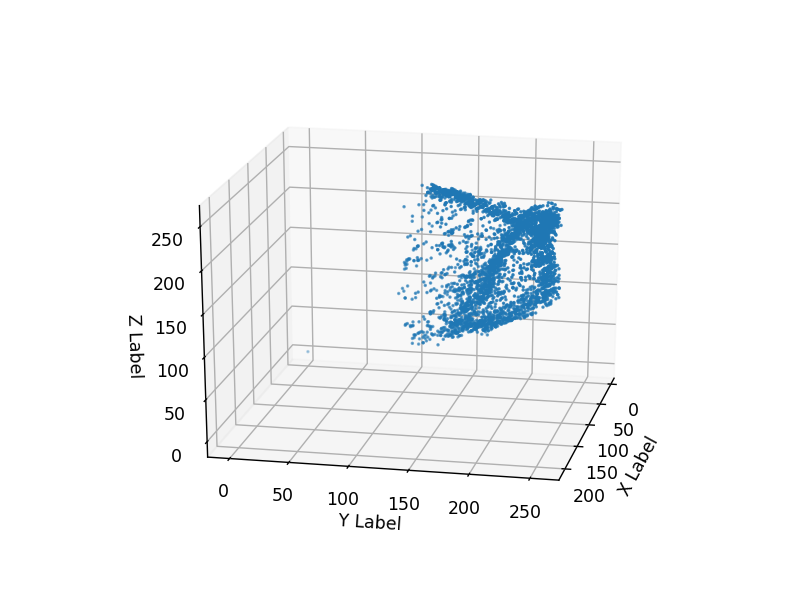

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
num = 4000
x =pixels[:num][:, 0]
y =pixels[:num][:, 1]
z =pixels[:num][:, 2]
ax.scatter(x,y,z, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [73]:
pixels[3]

array([124, 184, 133])

In [75]:
gmm = GMM(3,200,3, if_priors=True)
gmm.fit(pixels[1:])

In [76]:
gmm.means

array([[122, 176, 151],
       [ 93, 157, 248],
       [134, 234, 230]])

In [77]:
gmm.sigma

[array([[28.17114875,  0.        ,  0.        ],
        [ 0.        , 35.86329428,  0.        ],
        [ 0.        ,  0.        , 39.66073392]]),
 array([[17.09293908,  0.        ,  0.        ],
        [ 0.        , 25.4757013 ,  0.        ],
        [ 0.        ,  0.        ,  7.49317968]]),
 array([[30.70897997,  0.        ,  0.        ],
        [ 0.        , 11.08092368,  0.        ],
        [ 0.        ,  0.        ,  8.09200115]])]

In [65]:
gmm.fit(pixels[1:],iters=2)

In [66]:
gmm.means

array([[140, 200, 163],
       [120, 207, 236],
       [102, 142, 121]])

In [67]:
gmm.sigma

[array([[23.32589142,  0.        ,  0.        ],
        [ 0.        , 21.15995751,  0.        ],
        [ 0.        ,  0.        , 25.87849259]]),
 array([[32.94291624,  0.        ,  0.        ],
        [ 0.        , 40.02672666,  0.        ],
        [ 0.        ,  0.        , 11.90295467]]),
 array([[20.07997669,  0.        ,  0.        ],
        [ 0.        , 30.70031514,  0.        ],
        [ 0.        ,  0.        , 36.51832528]])]

In [78]:
gmm.priori

array([0.22577242, 0.26022667, 0.51400092])

In [79]:
np.save('dataset.npy', pixels[1:])

In [81]:
np.save('covar.npy', gmm.sigma)

In [82]:
 cv2.IMREAD_GRAYSCALE

0